# `litebird_sim` example on data splits

To run this notebook, you should create and activate a new virtual environment with the commands

```
python -m venv ./my_venv
source ./my_venv/bin/activate
```

(you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

```
pip install jupyter litebird_sim
```

If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a *development install* instead:

```
cd /my/local/copy/litebird_sim
pip install -e .
```

This notebook mimics for the first part the [litebird_sim_example](https://github.com/litebird/litebird_sim/blob/master/notebooks/litebird_sim_example.ipynb) notebook. The only difference in this part is the duration time of the simulation (2 year), the number of detectors (just one) and the fact that we initialize two simulations: one with the full two years, the other with just one year.

For further details on this part, refer to the [litebird_sim_example](https://github.com/litebird/litebird_sim/blob/master/notebooks/litebird_sim_example.ipynb) notebook.

## Set up the environment

In [1]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide

We start by importing a few libraries that will be useful in this notebook.

In [2]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import astropy

%matplotlib inline

# Parameters of the simulation

We will simulate one 140 GHz LFT detector. Its definition will be taken from the LiteBIRD Instrument MOdel (IMO) version vPTEP (**new!**), and we will simulate 24 months of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.

In [3]:
telescope = "LFT"
channel = "L4-140"
detlist = ["000_001_017_QB_140_T"]

start_time = astropy.time.Time("2025-01-01T00:00:00")
mission_time_days = 365 * 2

imo_version = "vPTEP"

# Resolution of the output maps
nside = 64

In [4]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
two_years_sim = lbs.Simulation(
    base_path=base_path,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
    random_seed=12345,  # seed for the random number generator (MANDATORY parameter!!!)
)

one_year_sim = lbs.Simulation(
    base_path=base_path,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0 / 2,
    random_seed=12345,  # seed for the random number generator (MANDATORY parameter!!!)
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.

In [5]:
# Load the definition of the instrument (MFT)
two_years_sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

one_year_sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

# filling dets with info and detquats with quaternions of the detectors in detlist
dets = []  # type: List[lbs.DetectorInfo]
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )

    # we overwrite the nominal sampling rate read from IMO with a smaller one, so that
    # we produce 1 yr tod without taking too much memory
    det.sampling_rate_hz = 1

    dets.append(det)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The following command will take some time: it needs to compute the ephemerides of the Earth with respect to the Ecliptic reference frame and derive the orientation of the MFT instrument as a function of time for the whole duration of the simulation. This step will be needed later, when we will obtain the pointings for the detectors involved in the simulation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/scanning.html#scanning-strategy) for more details about the scanning strategy.

In [6]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
two_years_sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

one_year_sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

Let's now create a set of «[observations](https://litebird-sim.readthedocs.io/en/latest/observations.html#observations)». This concept was mutuated by [TOAST](https://github.com/hpc4cmb/toast), and it represents a chunk of data acquired while the instrument was in almost stable conditions (i.e., stationary noise, no thermal drifts…). For the sake of simplicity, we create just *one* observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.

In [7]:
# creating one observation
two_years_sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)
one_year_sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

assert len(two_years_sim.observations) == 1
assert len(one_year_sim.observations) == 1

TODs are not enough to produce maps, as we need *pointing information* too: this is the direction and orientation of each receiver as a function of time.

So, here comes the part where we need to simulate the pointings. Much of the work has already been done, as the ephemerides were already computed in the call to `sim.set_scanning_strategy` (see above), but this step is going to take its time too, because we are now deriving the pointings for **each** detector and store them in the list `pointings`.

In [8]:
two_years_sim.set_hwp(
    lbs.IdealHWP(
        two_years_sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
two_years_sim.prepare_pointings()

one_year_sim.set_hwp(
    lbs.IdealHWP(
        one_year_sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
one_year_sim.prepare_pointings()

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the [frequency channel](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) we are simulating (140 GHz), so we retrieve them from the IMO again:

In [9]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

## Making TOD and maps of white noise

Let's add [white](https://litebird-sim.readthedocs.io/en/latest/timeordered.html#adding-noise) noise to the empty TOD

In [10]:
lbs.add_noise_to_observations(
    observations=two_years_sim.observations,
    noise_type="white",
    scale=1,
    dets_random=two_years_sim.dets_random,
)

lbs.add_noise_to_observations(
    observations=one_year_sim.observations,
    noise_type="white",
    scale=1,
    dets_random=one_year_sim.dets_random,
)

In [11]:
print(one_year_sim.observations[0].tod[0][:10])
print(two_years_sim.observations[0].tod[0][:10])

[ 6.87122592e-05 -1.87833557e-05  4.16064140e-05 -1.72945784e-05
 -2.07998401e-05  1.06021325e-05 -1.50002516e-05 -8.50068045e-06
  8.00324688e-06  6.70156733e-05]
[ 6.87122592e-05 -1.87833557e-05  4.16064140e-05 -1.72945784e-05
 -2.07998401e-05  1.06021325e-05 -1.50002516e-05 -8.50068045e-06
  8.00324688e-06  6.70156733e-05]


The TODs are filled with the same timestreams, as expected (see random seeds).

# Consistency checks with map-making

Now that the sims are filled with noise, we can start playing the the map-making procedure and data splits (see [docs](https://litebird-sim.readthedocs.io/en/master/mapmaking.html)).

Here, we want to check the consistency of the maps we can extract.

For the two-years observation, we ask for 3 splits: the full duration, the first half and the second half. Note that the first half of the two-years mission should be identical to the full duration of the one-year mission.

Let's first check this.

In [12]:
two_years_binner_results = two_years_sim.make_binned_map_splits(
    nside=nside,
    time_splits=["full", "first_half", "second_half"],
    detector_splits=["full"],
    append_to_report=False,
    write_to_disk=False,
)
print(two_years_binner_results.keys())

Splits are valid!
dict_keys(['full_full', 'full_first_half', 'full_second_half'])


In [13]:
two_years_m_noise = []
two_years_cov_noise = []
for i, key in enumerate(two_years_binner_results.keys()):
    print(f"The index {i} corresponds to the key {key}")
    two_years_m_noise.append(two_years_binner_results[key].binned_map)
    two_years_cov_noise.append(two_years_binner_results[key].invnpp)
two_years_m_noise = np.array(two_years_m_noise)
two_years_cov_noise = np.array(two_years_cov_noise)

The index 0 corresponds to the key full_full
The index 1 corresponds to the key full_first_half
The index 2 corresponds to the key full_second_half


In [14]:
one_year_binner_results = one_year_sim.make_binned_map(
    nside=nside,
    time_split="full",  # By default this is set to "full", so we could avoid specifying it here
    detector_split="full",  # Same for the detector split
    append_to_report=False,
)

In [15]:
one_year_m_noise = []
one_year_cov_noise = []
one_year_m_noise.append(one_year_binner_results.binned_map)
one_year_cov_noise.append(one_year_binner_results.invnpp)
one_year_m_noise = np.array(one_year_m_noise)
one_year_cov_noise = np.array(one_year_cov_noise)

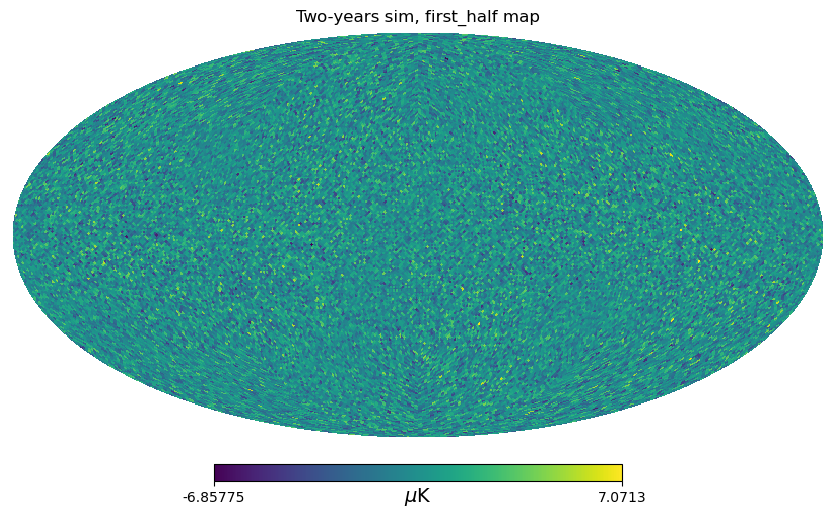

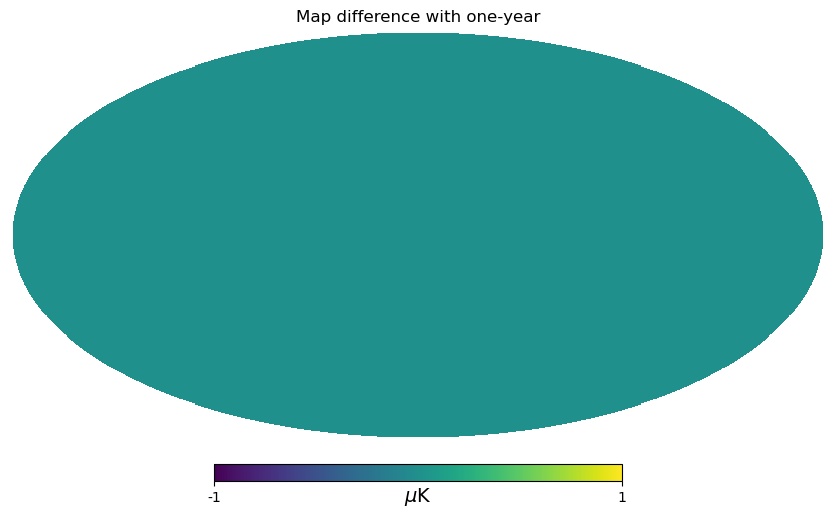

In [16]:
hp.mollview(
    1e6 * (two_years_m_noise[1, 0, :]),
    title="Two-years sim, first_half map",
    unit=r"$\mu$K",
)
hp.mollview(
    1e6 * (two_years_m_noise[1, 0, :] - one_year_m_noise[0, 0, :]),
    title="Map difference with one-year",
    unit=r"$\mu$K",
)

Indeed, we showed that the TODs are filled with the same random numbers, thus, since the map-making is deterministic, we obtain exactly the same map twice.

## Inspecting the splits

Now, we look into the splits of the two-years simulation.

Firstly, can we reconstruct the full two-year map from the splits?

We reconstruct the full covariance matrix from the two splits.

In [17]:
reconstructed_mat = np.linalg.inv(
    np.linalg.inv(two_years_cov_noise[1]) + np.linalg.inv(two_years_cov_noise[2])
)

print(
    f"The maximum percentage difference is {max(np.abs(two_years_cov_noise[0][:, 0, 0] - reconstructed_mat[:, 0, 0]) / two_years_cov_noise[0][:, 0, 0] * 100)} %"
)

del reconstructed_mat

The maximum percentage difference is 6.524179222829768e-12 %


The matrix is recovered spot-on! 

Now the full map.

In [18]:
# Store inverse noise covariance matrix
inv_cov_1 = np.linalg.inv(two_years_cov_noise[1])
inv_cov_2 = np.linalg.inv(two_years_cov_noise[2])

# Get terms for the reconstruction
term1 = []
for pix in range(hp.nside2npix(nside)):
    term1.append(two_years_m_noise[1, :, pix] @ (inv_cov_1[pix]))
term1 = np.array(term1).T

term2 = []
for pix in range(hp.nside2npix(nside)):
    term2.append(two_years_m_noise[2, :, pix] @ (inv_cov_2[pix]))
term2 = np.array(term2).T

reconstructed_full_map = (term1[0, :] + term2[0, :]) / (
    inv_cov_1[:, 0, 0] + inv_cov_2[:, 0, 0]
)

del inv_cov_1, inv_cov_2, term1, term2

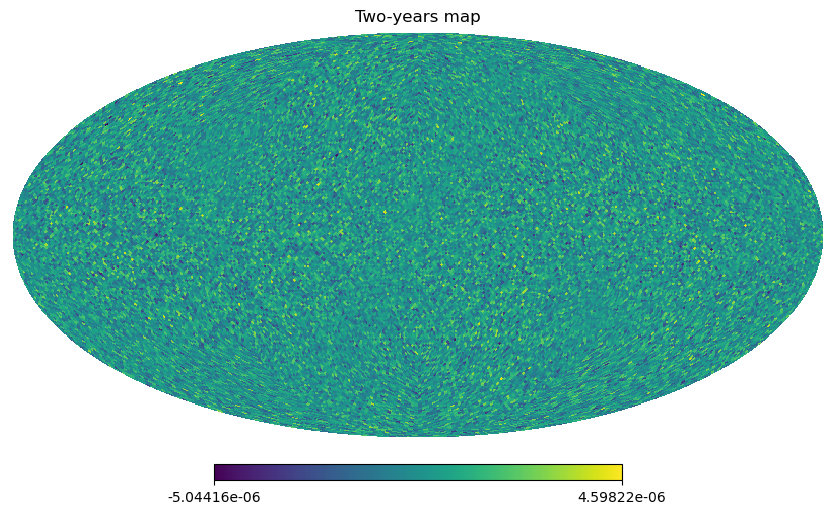

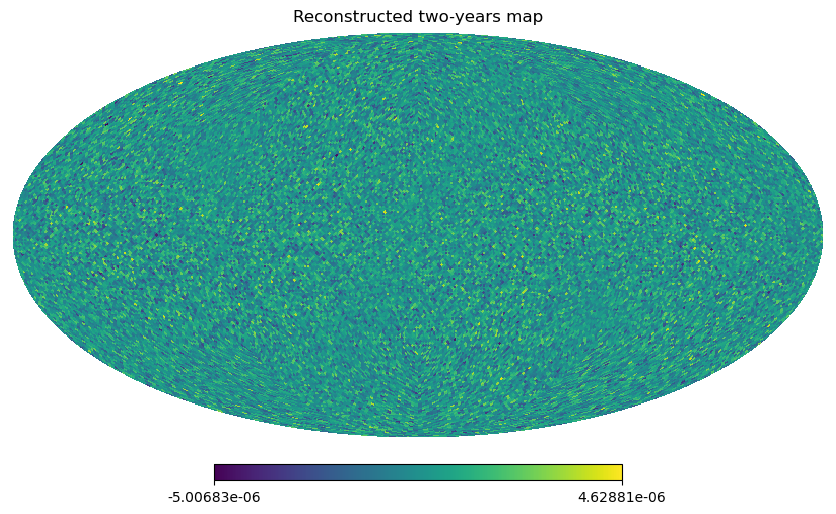

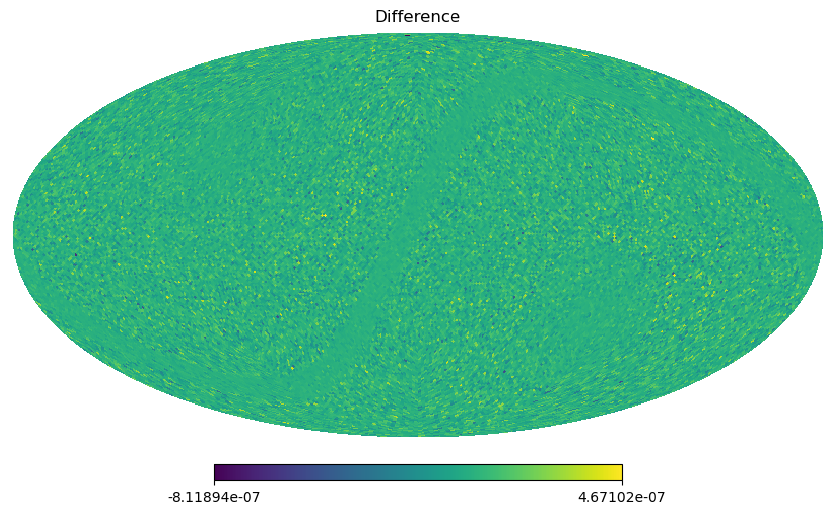

In [19]:
limiter = 2.5e-6
hp.mollview(two_years_m_noise[0, 0, :], title="Two-years map")
hp.mollview(reconstructed_full_map, title="Reconstructed two-years map")
hp.mollview(two_years_m_noise[0, 0, :] - reconstructed_full_map, title="Difference")

In [20]:
print(
    f"Maximum difference is {max(two_years_m_noise[0, 0, :] - reconstructed_full_map)}"
)
print(
    f"Minimum difference is {min(two_years_m_noise[0, 0, :] - reconstructed_full_map)}"
)

del reconstructed_full_map

Maximum difference is 4.6710184295088136e-07
Minimum difference is -8.118937598248251e-07


Recovering perfectly the map is tougher than the matrix...

For instance, if a pixel is not well observed by a split, it will have a large variance.

Indeed, note the the recontructed map correlate very well with the hits.

To get better agreement, one can increase the number of detectors or the duration.

## Spectra comparison

Let's check the angular power spectra of the various maps. In fact, dividing the mission in splits will give more noisy maps, which however are not correlated!

In [21]:
# Noise auto-spectra
cl_map_noise_two_years = hp.anafast(two_years_m_noise[0, 0, :] * 1e6)[2:]
cl_map_noise_two_years_first_half = hp.anafast(two_years_m_noise[1, 0, :] * 1e6)[2:]
cl_map_noise_two_years_second_half = hp.anafast(two_years_m_noise[2, 0, :] * 1e6)[2:]

# The noise of the two halfs do not correlate! Let's compute the cross-correlation
cl_map_noise_cross = hp.anafast(
    two_years_m_noise[1, 0, :] * 1e6, two_years_m_noise[2, 0, :] * 1e6
)[2:]

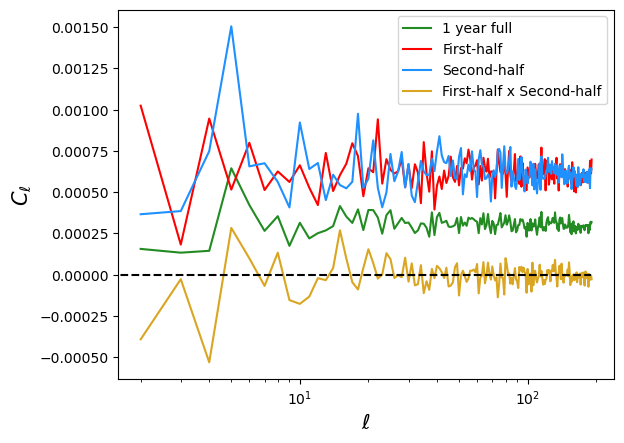

In [22]:
ell = np.arange(2, len(cl_map_noise_two_years) + 2)

plt.figure()
plt.plot(ell, cl_map_noise_two_years, color="forestgreen", label="1 year full")
plt.plot(ell, cl_map_noise_two_years_first_half, color="red", label="First-half")
plt.plot(
    ell, cl_map_noise_two_years_second_half, color="dodgerblue", label="Second-half"
)
plt.plot(ell, cl_map_noise_cross, color="goldenrod", label="First-half x Second-half")

plt.hlines(0, 0, len(cl_map_noise_two_years), color="black", linestyle="--")

plt.legend()
# plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_{\ell}$", fontsize=15)

plt.show()

As expected the noise one the single splits is larger than the two-years one as the
duration of the observation is halfened. However, the cross-spectrum is still very well 
compatible with zero.

This is a good check that the splits are independent.

## Making TOD and maps of white+1/f noise

Let's add [white + 1/f noise](https://litebird-sim.readthedocs.io/en/latest/timeordered.html#adding-noise) to the TOD (this will be added on top of the previous white noise, but this is not important for the purpose of this test)

In [23]:
# Let's free some memory
del one_year_binner_results, one_year_m_noise, one_year_cov_noise
del cl_map_noise_two_years, cl_map_noise_two_years_first_half
del cl_map_noise_two_years_second_half, cl_map_noise_cross

In [24]:
lbs.add_noise_to_observations(
    observations=two_years_sim.observations,
    noise_type="one_over_f",
    scale=1,
    dets_random=two_years_sim.dets_random,
)

Let's compare the noise maps done with the `litebird_sim` [binning mapmaker](https://litebird-sim.readthedocs.io/en/latest/mapmaking.html#binner) and with the [destriper](https://litebird-sim.readthedocs.io/en/latest/mapmaking.html#destriper).

In [25]:
destriper_params = lbs.DestriperParameters(
    samples_per_baseline=100,
    output_coordinate_system=lbs.coordinates.CoordinateSystem.Galactic,
    iter_max=10,
)

Splits are valid!


[2024-11-04 15:15:16,277 INFO MPI#0000] Destriper CG iteration 1/10, stopping factor: 5.680e-06
[2024-11-04 15:15:17,339 INFO MPI#0000] Destriper CG iteration 2/10, stopping factor: 1.219e-07
[2024-11-04 15:15:18,402 INFO MPI#0000] Destriper CG iteration 3/10, stopping factor: 1.219e-07
[2024-11-04 15:15:19,451 INFO MPI#0000] Destriper CG iteration 4/10, stopping factor: 1.219e-07
[2024-11-04 15:15:20,539 INFO MPI#0000] Destriper CG iteration 5/10, stopping factor: 1.333e-08
[2024-11-04 15:15:29,657 INFO MPI#0000] Destriper CG iteration 1/10, stopping factor: 4.962e-06
[2024-11-04 15:15:30,245 INFO MPI#0000] Destriper CG iteration 2/10, stopping factor: 1.305e-07
[2024-11-04 15:15:30,837 INFO MPI#0000] Destriper CG iteration 3/10, stopping factor: 1.305e-07
[2024-11-04 15:15:31,444 INFO MPI#0000] Destriper CG iteration 4/10, stopping factor: 1.305e-07
[2024-11-04 15:15:32,025 INFO MPI#0000] Destriper CG iteration 5/10, stopping factor: 1.957e-08
[2024-11-04 15:15:40,425 INFO MPI#0000] 

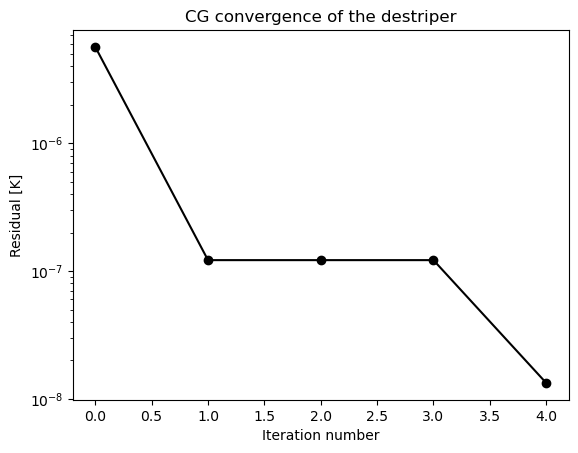

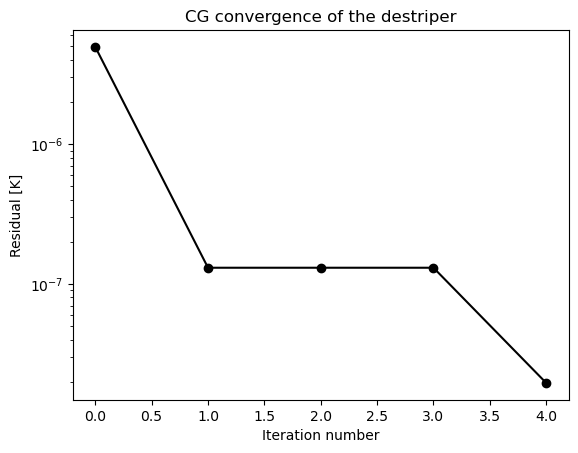

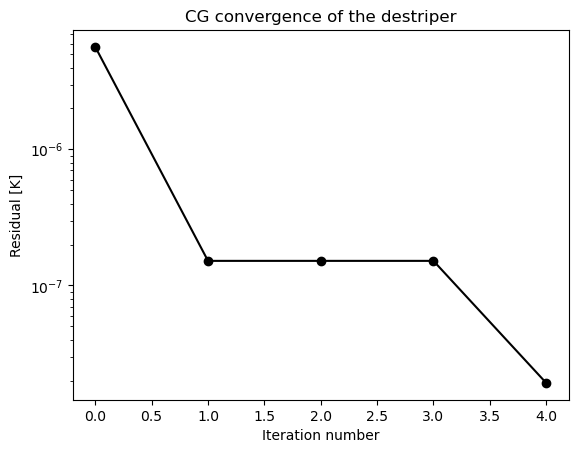

In [26]:
two_years_sim_destriper_result = two_years_sim.make_destriped_map_splits(
    nside=nside,
    params=destriper_params,
    time_splits=["full", "first_half", "second_half"],
    detector_splits=["full"],
    append_to_report=True,
    write_to_disk=False,
    recycle_baselines=False,
)

Note that the convergence check is repeated for each split, as each of them will find its own baseline solution.

Let's extract the binned and destriped maps.

In [27]:
two_years_dest_m_noise = []
two_years_binn_m_noise = []
for i, key in enumerate(two_years_sim_destriper_result.keys()):
    print(f"The index {i} corresponds to the key {key}")
    two_years_dest_m_noise.append(two_years_sim_destriper_result[key].destriped_map)
    two_years_binn_m_noise.append(two_years_sim_destriper_result[key].binned_map)
two_years_dest_m_noise = np.array(two_years_dest_m_noise)
two_years_binn_m_noise = np.array(two_years_binn_m_noise)

The index 0 corresponds to the key full_full
The index 1 corresponds to the key full_first_half
The index 2 corresponds to the key full_second_half


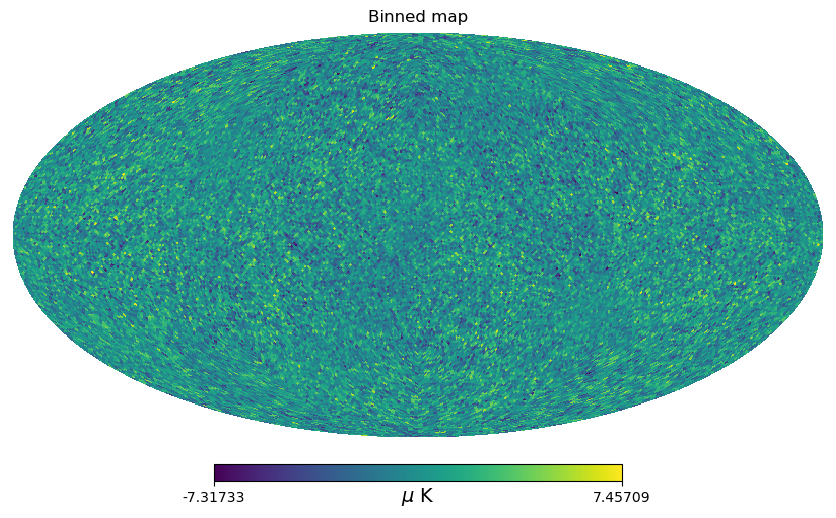

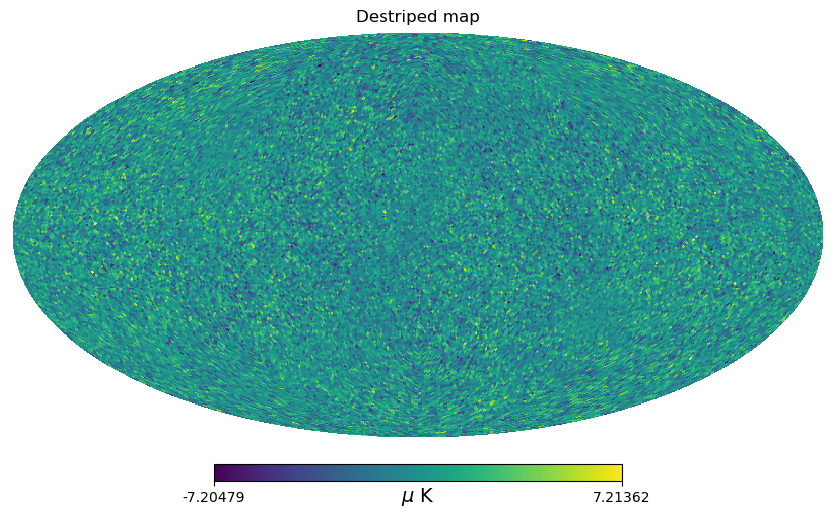

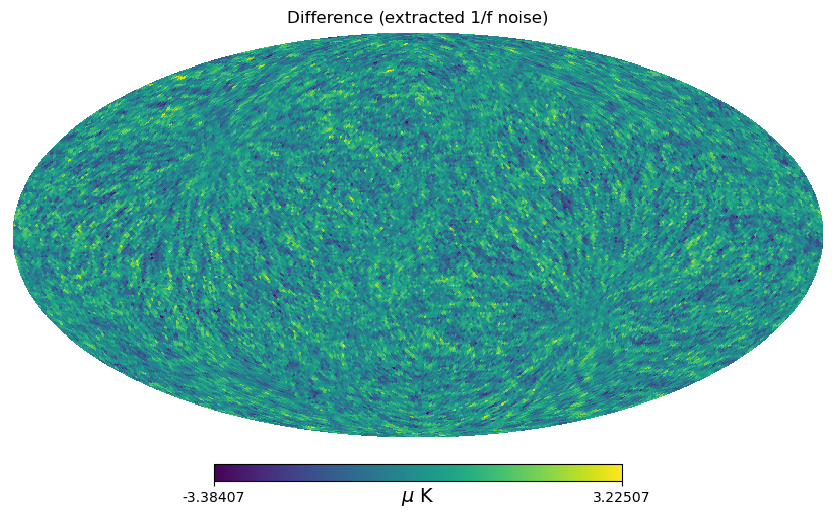

In [28]:
limits = 2.5
hp.mollview(
    1e6 * two_years_binn_m_noise[0, 0], unit=r"$\mu$ K", title="Binned map"
)  # , min=-limits, max=limits)
hp.mollview(
    1e6 * two_years_dest_m_noise[0, 0], unit=r"$\mu$ K", title="Destriped map"
)  # , min=-limits, max=limits)
hp.mollview(
    1e6 * (two_years_dest_m_noise[0, 0] - two_years_binn_m_noise[0, 0]),
    unit=r"$\mu$ K",
    title="Difference (extracted 1/f noise)",
)  # , min=-limits, max=limits)

In [29]:
cl_map_noise_bin = hp.anafast(two_years_binn_m_noise[0, 0])[2:]
cl_map_noise_destr = hp.anafast(two_years_dest_m_noise[0, 0])[2:]

first_half_cl_map_noise_bin = hp.anafast(two_years_binn_m_noise[1, 0])[2:]
second_half_cl_map_noise_bin = hp.anafast(two_years_binn_m_noise[2, 0])[2:]

first_half_cl_map_noise_destr = hp.anafast(two_years_dest_m_noise[1, 0])[2:]
second_half_cl_map_noise_destr = hp.anafast(two_years_dest_m_noise[2, 0])[2:]

cross_cl_map_noise_bin = hp.anafast(
    two_years_binn_m_noise[1, 0], two_years_binn_m_noise[2, 0]
)[2:]
cross_cl_map_noise_destr = hp.anafast(
    two_years_dest_m_noise[1, 0], two_years_dest_m_noise[2, 0]
)[2:]

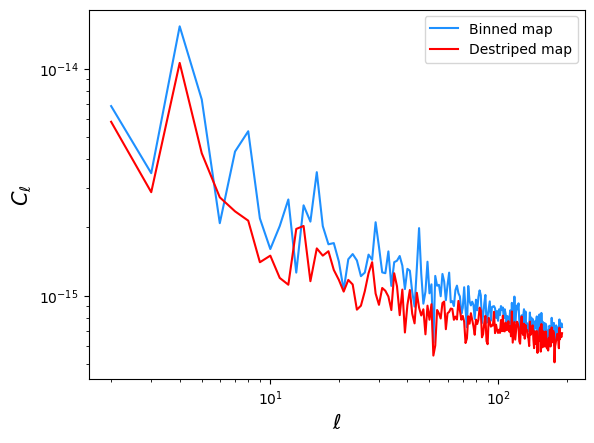

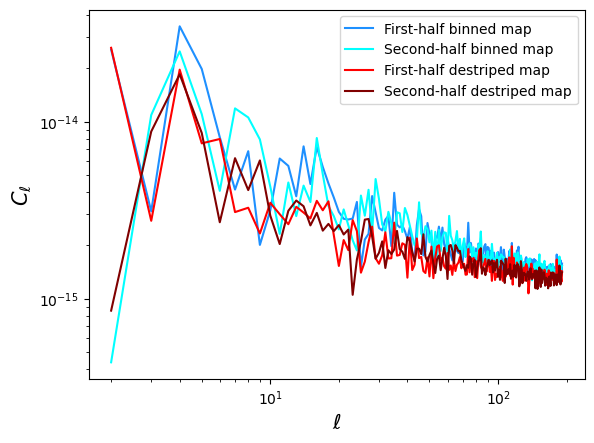

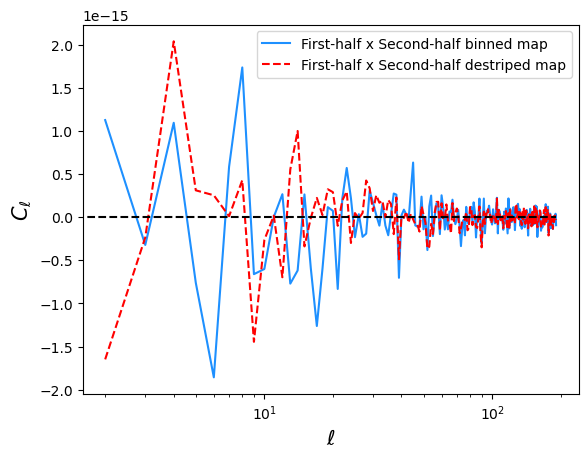

In [30]:
ell = np.arange(2, len(cl_map_noise_bin) + 2)

# Maps of two-years simulation, binned and destriped
plt.figure()
plt.plot(ell, cl_map_noise_bin, color="dodgerblue", label="Binned map")
plt.plot(ell, cl_map_noise_destr, color="red", label="Destriped map")

plt.legend()
plt.loglog()
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_{\ell}$", fontsize=15)

# Maps of two-years simulation, binned and destriped, split in two halves
plt.figure()
plt.plot(
    ell, first_half_cl_map_noise_bin, color="dodgerblue", label="First-half binned map"
)
plt.plot(
    ell, second_half_cl_map_noise_bin, color="cyan", label="Second-half binned map"
)
plt.plot(
    ell, first_half_cl_map_noise_destr, color="red", label="First-half destriped map"
)
plt.plot(
    ell,
    second_half_cl_map_noise_destr,
    color="maroon",
    label="Second-half destriped map",
)

plt.legend()
plt.loglog()
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_{\ell}$", fontsize=15)

# Cross-correlation of the two halves
plt.figure()
plt.plot(
    ell,
    cross_cl_map_noise_bin,
    color="dodgerblue",
    label="First-half x Second-half binned map",
)
plt.plot(
    ell,
    cross_cl_map_noise_destr,
    color="red",
    linestyle="--",
    label="First-half x Second-half destriped map",
)

plt.hlines(0, 0, len(cl_map_noise_bin), color="black", linestyle="--")

plt.legend()
plt.semilogx()
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_{\ell}$", fontsize=15)

plt.show()

The destriper is helping removing the 1/f noise, as expected. Note that both white noise and 1/f noise are not correlated through the splits. Thus, the cross-spectrum is compatible with zero in both cases.

## Recycling the baselines

As mentioned above, by default each split will search for its own baseline solution. However, we can recycle the baselines from the full split to speed up the map-making.

In [ ]:
two_years_sim_destriper_result = two_years_sim.make_destriped_map_splits(
    nside=nside,
    params=destriper_params,
    time_splits=["full", "first_half", "second_half"],
    detector_splits=["full"],
    append_to_report=True,
    write_to_disk=False,
    recycle_baselines=True,  # Recycle baselines
)

Splits are valid!


[2024-11-04 15:15:53,626 INFO MPI#0000] Destriper CG iteration 1/10, stopping factor: 5.680e-06
[2024-11-04 15:15:54,682 INFO MPI#0000] Destriper CG iteration 2/10, stopping factor: 1.219e-07
[2024-11-04 15:15:55,731 INFO MPI#0000] Destriper CG iteration 3/10, stopping factor: 1.219e-07
[2024-11-04 15:15:56,801 INFO MPI#0000] Destriper CG iteration 4/10, stopping factor: 1.219e-07
[2024-11-04 15:15:57,862 INFO MPI#0000] Destriper CG iteration 5/10, stopping factor: 1.333e-08


Note that this time the baseline solution is computed only once for the full split, and then just used for all the subsequent splits.

In [ ]:
two_years_dest_m_noise = []
two_years_binn_m_noise = []
for i, key in enumerate(two_years_sim_destriper_result.keys()):
    print(f"The index {i} corresponds to the key {key}")
    two_years_dest_m_noise.append(two_years_sim_destriper_result[key].destriped_map)
    two_years_binn_m_noise.append(two_years_sim_destriper_result[key].binned_map)
two_years_dest_m_noise = np.array(two_years_dest_m_noise)
two_years_binn_m_noise = np.array(two_years_binn_m_noise)

In [ ]:
# cl_map_original = hp.anafast(maps["L4-140"])
cl_map_noise_bin = hp.anafast(two_years_binn_m_noise[0, 0])[2:]
cl_map_noise_destr = hp.anafast(two_years_dest_m_noise[0, 0])[2:]

first_half_cl_map_noise_bin = hp.anafast(two_years_binn_m_noise[1, 0])[2:]
second_half_cl_map_noise_bin = hp.anafast(two_years_binn_m_noise[2, 0])[2:]

first_half_cl_map_noise_destr = hp.anafast(two_years_dest_m_noise[1, 0])[2:]
second_half_cl_map_noise_destr = hp.anafast(two_years_dest_m_noise[2, 0])[2:]

cross_cl_map_noise_bin = hp.anafast(
    two_years_binn_m_noise[1, 0], two_years_binn_m_noise[2, 0]
)[2:]
cross_cl_map_noise_destr = hp.anafast(
    two_years_dest_m_noise[1, 0], two_years_dest_m_noise[2, 0]
)[2:]

In [ ]:
ell = np.arange(2, len(cl_map_noise_bin) + 2)

# Maps of two-years simulation, binned and destriped
plt.figure()
plt.plot(ell, cl_map_noise_bin, color="dodgerblue", label="Binned map")
plt.plot(ell, cl_map_noise_destr, color="red", label="Destriped map")

plt.legend()
plt.loglog()
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_{\ell}$", fontsize=15)

# Maps of two-years simulation, binned and destriped, split in two halves
plt.figure()
plt.plot(
    ell, first_half_cl_map_noise_bin, color="dodgerblue", label="First-half binned map"
)
plt.plot(
    ell, second_half_cl_map_noise_bin, color="cyan", label="Second-half binned map"
)
plt.plot(
    ell, first_half_cl_map_noise_destr, color="red", label="First-half destriped map"
)
plt.plot(
    ell,
    second_half_cl_map_noise_destr,
    color="maroon",
    label="Second-half destriped map",
)

plt.legend()
plt.loglog()
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_{\ell}$", fontsize=15)

# Cross-correlation of the two halves
plt.figure()
plt.plot(
    ell,
    cross_cl_map_noise_bin,
    color="dodgerblue",
    label="First-half x Second-half binned map",
)
plt.plot(
    ell,
    cross_cl_map_noise_destr,
    color="red",
    linestyle="--",
    label="First-half x Second-half destriped map",
)

plt.hlines(0, 0, len(cl_map_noise_bin), color="black", linestyle="--")

plt.legend()
plt.semilogx()
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_{\ell}$", fontsize=15)

plt.show()

Recycling the baselines is good to same time. Indeed, the spectra obtained from the two-splits are actually better than before as they can exploit the complete information of the full split on the baselines. On the other hand, this common baseline solution is introducing an extra correlation between the splits. This is clear from the cross-spectrum, which is now non-zero on the large scales.